# Integrate People with Air Theme 1
Spatial join air team data with people.

## Description of Program
- program:    ip1_2dv2_joinpeopleair
- task:       Read Air files from CKAN - Join HUA with File
- Version:    2025-12-19
- 2026-02-16  Add Grid Cell ID from GPKG to HUA. Move to after hourly air code
- project:    Southeast Texas Urban Integrated Field Lab
- funding:	  DOE
- author:     Nathanael Rosenheim

## Step 0: Good Housekeeping

In [1]:
# 1. Import all packages
import pandas as pd     # For obtaining and cleaning tabular data
import geopandas as gpd # For obtaining and cleaning spatial data
import matplotlib.pyplot as plt # For plotting
import contextily as ctx # For adding basemaps
import os # For saving output to path
import zipfile # For handling zip files
import io # For handling in-memory data
import requests # For downloading data
import rasterio # For reading geotiff files

In [2]:
# 2. Check versions
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)

Python Version      3.13.9 | packaged by conda-forge | (main, Oct 22 2025, 23:12:41) [MSC v.1944 64 bit (AMD64)]
geopandas version:  1.1.1


In [3]:
# 3. Check working directory
# Get information on current working directory (getcwd)
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\GitHub\\integrate_people_theme1_cookbook'

In [62]:
#4. Store Program Name for output files to have the same name
programname = "ip1_2dv2_joinpeopleair"
# Make directory to save output
if not os.path.exists(programname):
    os.mkdir(programname)

In [5]:
# Functions to explore the housing unit allocation results
# load functions from Github repository
ncoda_00d_cleanvarsutils_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_00d_cleanvarsutils.py"
ncoda_04c_poptableresults_url = "https://github.com/npr99/intersect-community-data/raw/main/pyncoda/ncoda_04c_poptableresults.py"

import requests
import importlib.util

# Load the clean vars utils functions
response1 = requests.get(ncoda_00d_cleanvarsutils_url)
exec(response1.text)

# Load the pop table results functions - skip first 5 lines
response2 = requests.get(ncoda_04c_poptableresults_url)
# Split into lines, skip first 5, then rejoin
lines = response2.text.split('\n')
code_to_exec = '\n'.join(lines[5:])
exec(code_to_exec)

print("Successfully loaded functions from both GitHub repositories")

Successfully loaded functions from both GitHub repositories


# Step 1: Obtain Data
Obtain publicly available data on CKAN

https://ckan.tacc.utexas.edu/organization/setx-uifl

- Housing unit level population data allocated to structures
- Study site boundaries
- Social Vulnerability Data
- Air pollution

In [6]:
# housing unit allocation data from CKAN
data_title = "2020 Housing Unit Allocation for SETX"
url = "https://ckan.tacc.utexas.edu/dataset/62308724-7eac-45ed-aeab-d4d6a46128e1/resource/5154eb5e-d8ff-4183-b361-fd530513e3c1/download/hua_v2-0-0_setxuifl_tx_nsi_2020_nsi_rs9876.csv"

# read in blockid, bgid, tractid, FIPSCounty as strings
dtypes_dict = {
    'blockid': str,
    'bgid': str,
    'tractid': str,
    'FIPSCounty': str
}
hua_df = pd.read_csv(url, dtype=dtypes_dict)
hua_df.head(1)

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2020_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,2.0,ST00nsi-481325235-86274HQQ+WH4-8-3-8-4AP000000,nsi-481325235-86274HQQ+WH4-8-3-8-4,0.0,1.0,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.411062 30.139761)


In [7]:
# from hua_df drop observations missing huid
print(f"Original hua_df shape: {hua_df.shape}")
hua_df = hua_df.dropna(subset=['huid'])
print(f"After dropping missing huid: {hua_df.shape}")

Original hua_df shape: (226925, 36)
After dropping missing huid: (192639, 36)


In [8]:
# drop columns from hua_df
columns_to_drop = [
    'BLOCKID20_str',
    'huicounter1',
    'huicounter2', 
    'huicounter3',
    'ownershp1',
    'ownershp2', 
    'ownershp3',
    'strctid',
    'strctid_flagsetrm',
    'strctid_Block2020_flagsetrm',
    'addrptid',
    'fd_id_bid',
    'huestimate',
    'huicounter_addpt'
]

# Drop columns if they exist (errors='ignore' prevents KeyError for missing columns)
hua_df = hua_df.drop(columns=columns_to_drop, errors='ignore')
print(f"Columns dropped. New hua_df shape: {hua_df.shape}")
print(f"Remaining columns: {list(hua_df.columns)}")

Columns dropped. New hua_df shape: (192639, 22)
Remaining columns: ['huid', 'Block2020', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec', 'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype', 'incomegroup', 'hhinc', 'randincome', 'poverty', 'placeNAME20', 'x', 'y', 'occtype', 'geometry']


In [9]:
# task force sites
data_title = "Task Force Top Two Focus Sites"
url = "https://ckan.tacc.utexas.edu/dataset/cfe91d1b-3aa9-4de1-ba76-2837deb87649/resource/7e2e3d0e-60cc-4fb1-beea-d30a62cdd1e9/download/task_force_sites_top_focus_may_2024.zip"

tfsites_gdf = gpd.read_file(url)
tfsites_gdf.head()

,Shape_Leng,Shape_Area,Site_Name,geometry
0,0.0,0.0,West Port Arthur - Foley Watershed,"POLYGON Z ((-10458830.588 3488032.728 0, -1045..."
1,0.0,0.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-10476419.371 3513315.472 0, -1047..."


In [10]:
# Add SVI data by tract and block group https://ckan.tacc.utexas.edu/dataset/social-vulnerability-southeast-texas
data_title = "2020 SVI Data for SETX Block Groups"
blockgroup_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/8c77ff75-e8dc-436c-af09-d353b7adea0c/download/tu3svi4_2av2_svioptions_2025-04-16_bg2020_setx.zip'
blockgroup_svi_gdf = gpd.read_file(blockgroup_svi_url)
blockgroup_svi_gdf.head(1)

,BG2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,TRACT2020,airsite_bg,airsite_na,geometry
0,482450108004,1805083,0,0.11097,0.33012,0.0,-24429.0,-0.03282,-185900.0,1033.0,...,0.323,1.0,1.0,1.0,1.0,48245,48245010800,0.0,None,"POLYGON ((-93.96848 29.98396, -93.96712 29.985..."


In [11]:
data_title = "2020 SVI Data for SETX Tracts"
tract_svi_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/112f6e55-f843-46bc-bd2f-952753efbab2/download/tu3svi4_2av2_svioptions_2025-04-16_tract2020_setx.zip'
tract_svi_gdf = gpd.read_file(tract_svi_url)
tract_svi_gdf.head(1)

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."


In [12]:
data_title = "2020 SVI Data Dictionary"
svi_datadictionary_url = 'https://ckan.tacc.utexas.edu/dataset/aba7c155-b112-45a5-8a6f-d826cda08c8f/resource/c25d8010-a142-4ee8-8eea-fe7fa3ca4b4d/download/tu3svi4_2av2_svioptions_2025-04-16_all_vars_datadictionary.csv.xlsx'
# read in xlsx file
svi_datadictionary_df = pd.read_excel(svi_datadictionary_url)
svi_datadictionary_df.head(1)


,SVI,year,newvarname,SVIcat,label,oldvarname
0,CDC,2020,C202010010,Geocode,Census Tract 11 Digit Geocode,FIPS


In [13]:
# read in cleaned air data from ip1_2av2_airgridtogpkg
source_programname = "ip1_2av2_airgridtogpkg"
source_filename_1km = "ip1_2av2_airgridtogpkg_grid_1km.gpkg"
source_filename_4km = "ip1_2av2_airgridtogpkg_grid_4km.gpkg"

grid_1km_gdf = gpd.read_file(os.path.join(source_programname, source_filename_1km))
grid_4km_gdf = gpd.read_file(os.path.join(source_programname, source_filename_4km))

In [14]:
grid_1km_gdf.head(1)

,air_grid_id1km,row_idx,col_idx,geometry
0,airuifl_1km_0000_0000,0,0,"POLYGON ((-94.39218 30.22502, -94.38184 30.224..."


In [15]:
# Check CRS for both grids
grid_4km_gdf.crs
grid_1km_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
grid_4km_gdf.head(1)

,air_grid_id4km,row_idx,col_idx,geometry
0,airuifl_4km_0000_0000,0,0,"POLYGON ((-95.84949 32.4834, -95.80688 32.4829..."


# Step 2: Clean Data

In [17]:
# convert hua_df to a GeoDataFrame
# use geometry column
hua_gdf = gpd.GeoDataFrame(hua_df, geometry=gpd.GeoSeries.from_wkt(hua_df['geometry']), crs="EPSG:4326")
hua_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,gqtype,incomegroup,hhinc,randincome,poverty,placeNAME20,x,y,occtype,geometry
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976)
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989)
6,B481990302002007H011,481990302002007,481990302002007,481990302002,48199030200,48199.0,5.0,2.0,1.0,0.0,...,0.0,15.0,5.0,166290.0,0.0,Sour Lake,-94.407034,30.139050,RES1-2SNB,POINT (-94.40703 30.13905)
7,B481990302002007H007,481990302002007,481990302002007,481990302002,48199030200,48199.0,1.0,2.0,1.0,0.0,...,0.0,12.0,4.0,79927.0,0.0,Sour Lake,-94.409895,30.139030,RES1-1SNB,POINT (-94.4099 30.13903)
8,B481990302002007H012,481990302002007,481990302002007,481990302002,48199030200,48199.0,4.0,2.0,6.0,0.0,...,0.0,11.0,3.0,63085.0,0.0,Sour Lake,-94.409085,30.139856,RES1-1SNB,POINT (-94.40908 30.13986)


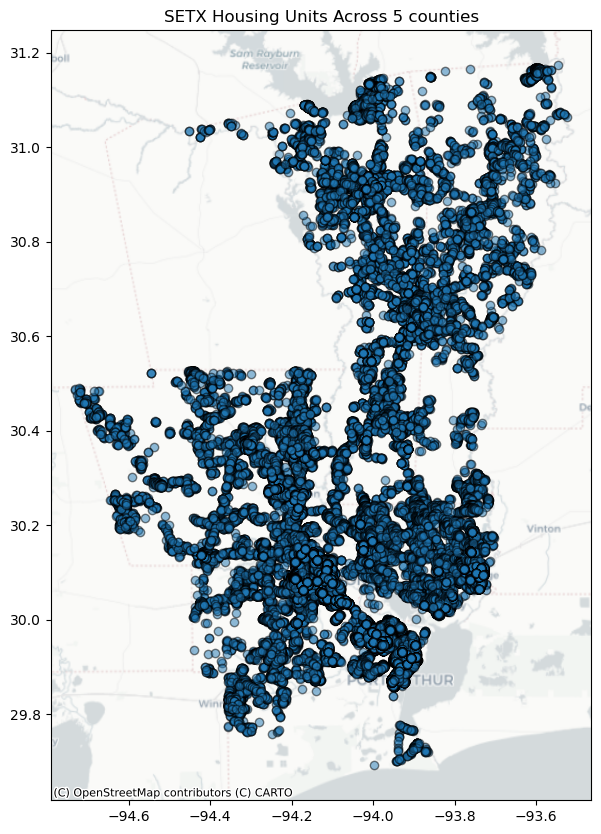

In [18]:
# make a map of points with basemap
ax = hua_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=hua_gdf.crs, source=ctx.providers.CartoDB.Positron)
# add title 
ax.set_title("SETX Housing Units Across 5 counties")
plt.show()


In [19]:
hua_gdf['huid'].describe()

count                   192639
unique                  192639
top       B481990302002008H002
freq                         1
Name: huid, dtype: object

In [20]:
# sum numprec
print(f"Total number of people (numprec): {hua_gdf['numprec'].sum()}")

Total number of people (numprec): 440607.0


<Axes: >

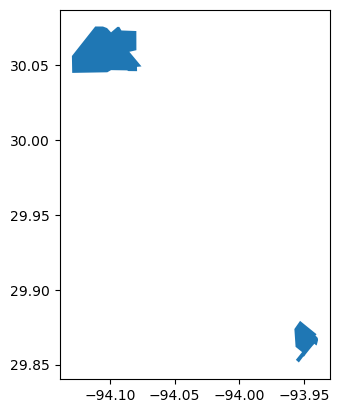

In [21]:
# convert task force site CRS to match hua_gdf
tfsites_gdf = tfsites_gdf.to_crs(hua_gdf.crs)
tfsites_gdf.plot()

In [22]:
# add site id to task force gdf
tfsites_gdf['Site_ID'] = tfsites_gdf.index + 1
tfsites_gdf = tfsites_gdf[['Site_ID','Site_Name', 'geometry']]
tfsites_gdf.head()

,Site_ID,Site_Name,geometry
0,1,West Port Arthur - Foley Watershed,"POLYGON Z ((-93.95327 29.87921 0, -93.94959 29..."
1,2,Southeast Beaumont - Hillebrant Bayou/Tenmile ...,"POLYGON Z ((-94.11128 30.07594 0, -94.10533 30..."


### Spatial Join
Add Task Force Site ID to HUA

In [23]:
# spatial join hua_gdf with tfsites_gdf
hua_tfsites_gdf = gpd.sjoin(hua_gdf, tfsites_gdf, how="left", predicate="intersects")
hua_tfsites_gdf.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,randincome,poverty,placeNAME20,x,y,occtype,geometry,index_right,Site_ID,Site_Name
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,NaN,NaN,Sour Lake,-94.411062,30.139761,COM1,POINT (-94.41106 30.13976),NaN,NaN,NaN
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,NaN,NaN,Sour Lake,-94.410730,30.139890,COM4,POINT (-94.41073 30.13989),NaN,NaN,NaN
6,B481990302002007H011,481990302002007,481990302002007,481990302002,48199030200,48199.0,5.0,2.0,1.0,0.0,...,166290.0,0.0,Sour Lake,-94.407034,30.139050,RES1-2SNB,POINT (-94.40703 30.13905),NaN,NaN,NaN
7,B481990302002007H007,481990302002007,481990302002007,481990302002,48199030200,48199.0,1.0,2.0,1.0,0.0,...,79927.0,0.0,Sour Lake,-94.409895,30.139030,RES1-1SNB,POINT (-94.4099 30.13903),NaN,NaN,NaN
8,B481990302002007H012,481990302002007,481990302002007,481990302002,48199030200,48199.0,4.0,2.0,6.0,0.0,...,63085.0,0.0,Sour Lake,-94.409085,30.139856,RES1-1SNB,POINT (-94.40908 30.13986),NaN,NaN,NaN


In [24]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_tracts = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_tracts.groupby(['Site_ID','tractid']).size()


Site_ID  tractid    
1.0      48245005100     427
         48245005900     582
2.0      48245001200      73
         48245001700     748
         48245001900    1034
         48245002000     873
         48245002100    1034
         48245002200     583
         48245002300     913
         48245002400    1083
         48245002500     291
         48245002600     581
         48245011700     158
dtype: int64

In [25]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_tracts.groupby('Site_ID')['tractid'].nunique()

Site_ID
1.0     2
2.0    11
Name: tractid, dtype: int64

In [26]:
#  select census tracts that intersect with task force sites
hua_tfsites_gdf_bg = hua_tfsites_gdf[~hua_tfsites_gdf['Site_ID'].isna()]
# summarize number of tracts intersecting with each site
hua_tfsites_gdf_bg.groupby(['Site_ID','bgid']).size()

Site_ID  bgid        
1.0      482450051001    213
         482450051002    214
         482450059001    406
         482450059002    176
2.0      482450012002     73
         482450017001    271
         482450017002    243
         482450017003    234
         482450019001    340
         482450019002    245
         482450019003    449
         482450020001    316
         482450020002    557
         482450021001    123
         482450021002    569
         482450021003    342
         482450022001    213
         482450022002    131
         482450022003    239
         482450023001    322
         482450023002    309
         482450023003    202
         482450023004     80
         482450024001    256
         482450024002    268
         482450024003    268
         482450024004    291
         482450025001    291
         482450026002     45
         482450026004    536
         482450117002    158
dtype: int64

In [27]:
# how many unique tracts intersect with task force sites
# count by Site_ID
hua_tfsites_gdf_bg.groupby('Site_ID')['bgid'].nunique()

Site_ID
1.0     4
2.0    27
Name: bgid, dtype: int64

In [28]:
tract_svi_gdf.head()

,TRACT2020,ALAND,AWATER,U202020010,U202020013,U202020020,U202020031,U202020033,U202020040,U202020070,...,H202090093,H202091012,H202091093,H202092021,SETX,FIPSCNTY,airsite_tr,airsite_na,area_m^2,geometry
0,48351950100,779155722,9905672,0.31786,0.43767,0.13483,-23537.0,-0.00928,-77100.0,827.0,...,0.594,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.91113 31.15807, -93.90629 31.158..."
1,48351950300,485357049,2214858,0.30314,0.51767,0.09422,-20002.0,-0.00000,-67800.0,632.0,...,0.542,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.88919 30.43845, -93.88899 30.441..."
2,48351950400,296202703,605235,0.19510,0.37127,0.06878,-26501.0,-0.04757,-101900.0,821.0,...,0.519,3.0,3.0,1.0,1.0,48351,0.0,None,NaN,"POLYGON ((-93.90145 30.25293, -93.90145 30.252..."
3,48241950701,344503029,3181130,0.03623,0.37354,0.10871,-35488.0,-0.04386,-113200.0,584.0,...,0.382,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.12066 30.28106, -94.12042 30.281..."
4,48241950102,444058152,6807777,0.11693,0.43997,0.06844,-39065.0,-0.08815,-93800.0,1087.0,...,0.450,2.0,2.0,1.0,1.0,48241,0.0,None,NaN,"POLYGON ((-94.46017 31.03122, -94.45981 31.031..."


In [29]:
# make list of unique tracts in site list with sitename
# get unique tract/site combinations
tract_site_df = hua_tfsites_gdf_tracts[['tractid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
tract_site_df = tract_site_df.dropna()
tract_site_df

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,48245001900,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
68991,48245005100,1.0,West Port Arthur - Foley Watershed
88417,48245002600,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
88915,48245001700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
89712,48245002500,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [30]:
# make list of unique bg in site list with sitename
# get unique bg/site combinations
bg_site_df = hua_tfsites_gdf_tracts[['bgid','Site_ID','Site_Name']].drop_duplicates()
# drop Nan Tractids
bg_site_df = bg_site_df.dropna()
bg_site_df

,bgid,Site_ID,Site_Name
36122,482450059001,1.0,West Port Arthur - Foley Watershed
37720,482450022002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,482450024003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,482450021003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,482450117002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45437,482450019003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
49845,482450021001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50060,482450022003,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50810,482450024002,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
50903,482450022001,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


In [31]:
tract_site_df.head()

,tractid,Site_ID,Site_Name
36122,48245005900,1.0,West Port Arthur - Foley Watershed
37720,48245002200,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
40816,48245002400,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
42090,48245002100,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...
45309,48245011700,2.0,Southeast Beaumont - Hillebrant Bayou/Tenmile ...


<Axes: >

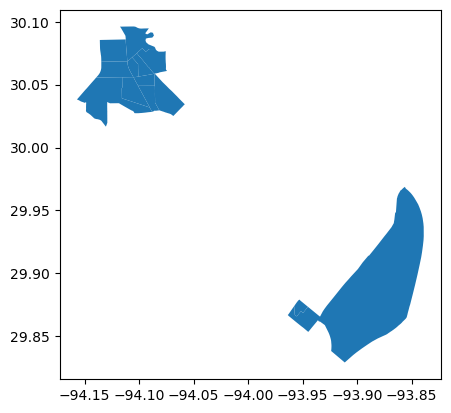

In [32]:
# merge tract_site_df with tract_svi_gdf
tract_site_gdf = tract_svi_gdf.merge(tract_site_df, left_on='TRACT2020', right_on='tractid')
# keep if site id is not null
tract_site_gdf = tract_site_gdf[~tract_site_gdf['Site_ID'].isna()]
tract_site_gdf.plot()

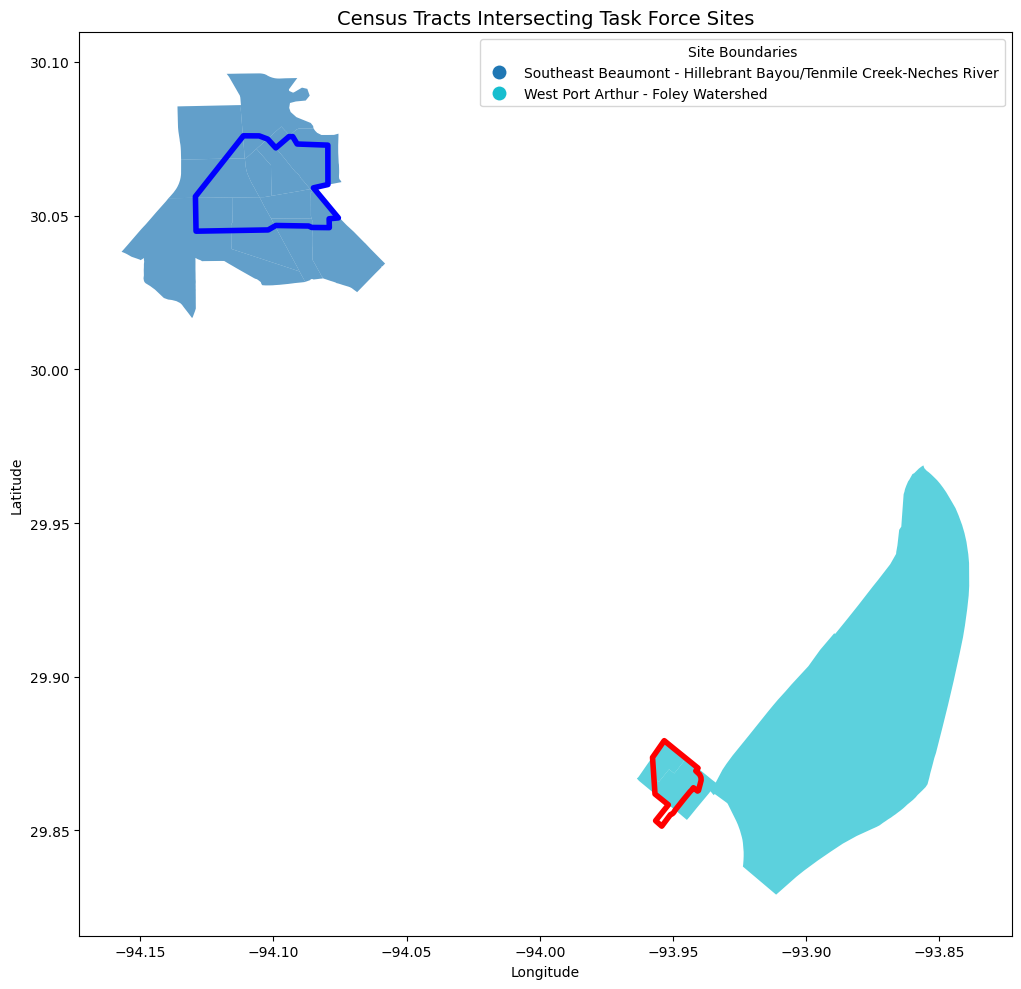

In [33]:
# make a map that shows the task force sites and the intersecting census tracts
fig, ax = plt.subplots(figsize=(12, 10))

# Plot census tracts colored by Site_Name
tract_site_gdf.plot(column='Site_Name', legend=True, ax=ax, alpha=0.7, 
                   legend_kwds={'title': 'Task Force Sites'})

# Plot task force sites as colored outlines based on Site_Name
tfsites_gdf.plot(ax=ax, facecolor='none', column='Site_Name', 
                edgecolor=['red', 'blue'], linewidth=4, legend=True,
                legend_kwds={'title': 'Site Boundaries', 'loc': 'upper right'})

plt.title("Census Tracts Intersecting Task Force Sites", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

## Add SVI variables
From tract_svi_gdf and blockgroup_svi_gdf add key SVI scores

https://ckan.tacc.utexas.edu/dataset/social-vulnerability-southeast-texas 


Note that the primary variables to use are:
- C202090012 Index Total CDC Overall Percentile Ranking for Texas 
- H202090012 Index Total HRRC TAMU Statewide Percentile Rank 
- U202090012 Index Total SVInsight Factor Analysis Scaled 0 to 1 Normalized Across Texas

In [34]:
tract_svi_gdf[['TRACT2020','C202090012','H202090012','U202090012']].head()

,TRACT2020,C202090012,H202090012,U202090012
0,48351950100,62.36,67.1,76.381
1,48351950300,56.60,58.1,83.165
2,48351950400,45.48,54.4,56.557
3,48241950701,26.73,29.3,35.634
4,48241950102,48.79,41.8,83.150


In [35]:
blockgroup_svi_gdf[['BG2020','H202090012','U202090012']].head()

,BG2020,H202090012,U202090012
0,482450108004,20.9,25.665
1,482450108003,16.6,37.344
2,482450108005,19.8,45.993
3,482450108001,23.1,28.092
4,482450109012,14.0,52.622


In [36]:
# Merge tract SVI data with hua_tfsites_gdf
tract_svi_subset = tract_svi_gdf[['TRACT2020','C202090012','H202090012','U202090012']]
# Rename BG columns to avoid conflicts with tract columns
tract_svi_subset = tract_svi_subset.rename(columns={'C202090012':'CDCSVI_TRACT', 'H202090012': 'HRRCSVI_TRACT', 'U202090012': 'SVInsight_TRACT'})

hua_tfsites_gdf_with_tract_svi = hua_tfsites_gdf.merge(tract_svi_subset, 
                                                       left_on='tractid', 
                                                       right_on='TRACT2020', 
                                                       how='left')

# Merge block group SVI data 
bg_svi_subset = blockgroup_svi_gdf[['BG2020','H202090012','U202090012']]
# Rename BG columns to avoid conflicts with tract columns
bg_svi_subset = bg_svi_subset.rename(columns={'H202090012': 'HRRCSVI_BG', 'U202090012': 'SVInsight_BG'})

hua_tfsites_gdf_with_svi = hua_tfsites_gdf_with_tract_svi.merge(bg_svi_subset, 
                                                                left_on='bgid', 
                                                                right_on='BG2020', 
                                                                how='left')

# Show sample with SVI variables
svi_columns = ['tractid', 'bgid', 'CDCSVI_TRACT', 'HRRCSVI_TRACT', 'SVInsight_TRACT', 'HRRCSVI_BG', 'SVInsight_BG']
hua_tfsites_gdf_with_svi[svi_columns].head()

,tractid,bgid,CDCSVI_TRACT,HRRCSVI_TRACT,SVInsight_TRACT,HRRCSVI_BG,SVInsight_BG
0,48199030200,481990302002,42.26,49.0,45.744,74.3,46.351
1,48199030200,481990302002,42.26,49.0,45.744,74.3,46.351
2,48199030200,481990302002,42.26,49.0,45.744,74.3,46.351
3,48199030200,481990302002,42.26,49.0,45.744,74.3,46.351
4,48199030200,481990302002,42.26,49.0,45.744,74.3,46.351


## Add Air Grid Data 

Air Grid Data converted to vector geopackage in previous code. Should be able to use spatial join.

In [37]:
def spatial_join_grid_to_hua(grid_gdf, hua_gdf, resolution_name, join_type='intersects', include_grid_info=True):
    """
    Spatially join grid data (1km or 4km) to HUA (Housing Unit Allocation) data
    
    Parameters:
    -----------
    grid_gdf : geopandas.GeoDataFrame
        Grid GeoDataFrame (either grid_1km_gdf or grid_4km_gdf)
    hua_gdf : geopandas.GeoDataFrame  
        HUA GeoDataFrame containing housing unit data
    resolution_name : str
        Name to identify the resolution ('1km' or '4km')
    join_type : str
        Type of spatial join ('intersects', 'within', 'contains')
    include_grid_info : bool
        Whether to include grid geometry and metadata in result
        
    Returns:
    --------
    geopandas.GeoDataFrame
        HUA data with grid information spatially joined
    """
    
    print(f"Performing spatial join between {resolution_name} grid and HUA data...")
    print(f"Grid shape: {grid_gdf.shape}")
    print(f"HUA shape: {hua_gdf.shape}")
    
    # Clean up existing join columns to avoid conflicts
    hua_clean = hua_gdf.copy()
    grid_clean = grid_gdf.copy()
    
    # Remove any existing index_right columns or similar join artifacts
    join_columns_to_remove = ['index_right', 'index_left']
    for col in join_columns_to_remove:
        if col in hua_clean.columns:
            print(f"Removing existing '{col}' column from HUA data")
            hua_clean = hua_clean.drop(col, axis=1)
        if col in grid_clean.columns:
            print(f"Removing existing '{col}' column from grid data")
            grid_clean = grid_clean.drop(col, axis=1)
    
    # Ensure both datasets are in the same CRS
    if grid_clean.crs != hua_clean.crs:
        print(f"Reprojecting grid from {grid_clean.crs} to {hua_clean.crs}")
        grid_gdf_proj = grid_clean.to_crs(hua_clean.crs)
    else:
        grid_gdf_proj = grid_clean.copy()
    
    # Perform spatial join with custom suffix to avoid conflicts
    # HUA data as left (keeps all HUA records), grid as right
    hua_with_grid = gpd.sjoin(hua_clean, grid_gdf_proj, how='left', predicate=join_type, rsuffix=f'_{resolution_name}')
    
    # Rename the index_right column to be more descriptive
    if 'index_right' in hua_with_grid.columns:
        hua_with_grid = hua_with_grid.rename(columns={'index_right': f'{resolution_name}_grid_index'})

    return hua_with_grid


In [38]:
# Join 1km grid to HUA data
hua_with_1km_grid = spatial_join_grid_to_hua(
    grid_gdf=grid_1km_gdf, 
    hua_gdf=hua_tfsites_gdf_with_svi, 
    resolution_name='1km'
)

# Join 4km grid to HUA data with 1km grid data
hua_with_grid = spatial_join_grid_to_hua(
    grid_gdf=grid_4km_gdf,
    hua_gdf=hua_with_1km_grid, 
    resolution_name='4km'
)

Performing spatial join between 1km grid and HUA data...
Grid shape: (5184, 4)
HUA shape: (192639, 32)
Removing existing 'index_right' column from HUA data
Performing spatial join between 4km grid and HUA data...
Grid shape: (8019, 4)
HUA shape: (192639, 35)


In [42]:
hua_with_grid.head()

,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,HRRCSVI_BG,SVInsight_BG,index__1km,air_grid_id1km,row_idx_left,col_idx_left,index__4km,air_grid_id4km,row_idx__4km,col_idx__4km
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,74.3,46.351,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,74.3,46.351,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35
2,B481990302002007H011,481990302002007,481990302002007,481990302002,48199030200,48199.0,5.0,2.0,1.0,0.0,...,74.3,46.351,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35
3,B481990302002007H007,481990302002007,481990302002007,481990302002,48199030200,48199.0,1.0,2.0,1.0,0.0,...,74.3,46.351,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35
4,B481990302002007H012,481990302002007,481990302002007,481990302002,48199030200,48199.0,4.0,2.0,6.0,0.0,...,74.3,46.351,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35


In [42]:
# describe air_grid_id1km variable
hua_with_grid['air_grid_id1km'].describe()

count                    147237
unique                     1464
top       airuifl_1km_0016_0021
freq                       1287
Name: air_grid_id1km, dtype: object

### Merge in Hourly Air Data

In [44]:
sourceprogramname = "ip1_2cv3_hourlyair"
output_filename = "ip1_2cv3_hourlyair_summed_benz_1km.csv"
hourly_air_df = pd.read_csv(os.path.join(sourceprogramname, output_filename))
hourly_air_df.head()

,ROW,COL,BENZ,x,y,grid_id
0,0,0,0.085695,110.0,-1222.0,airuifl_1km_0000_0000
1,0,1,0.085111,114.0,-1222.0,airuifl_1km_0000_0001
2,0,2,0.084533,118.0,-1222.0,airuifl_1km_0000_0002
3,0,3,0.083564,122.0,-1222.0,airuifl_1km_0000_0003
4,0,4,0.081309,126.0,-1222.0,airuifl_1km_0000_0004


In [45]:
# describe air_grid_id1km variable
hourly_air_df['grid_id'].describe()

count                      5184
unique                     5184
top       airuifl_1km_0000_0000
freq                          1
Name: grid_id, dtype: object

In [46]:
# merge hourly air data with hua_with_grid on 1km grid index
hua_with_hourly_air = hua_with_grid.merge(hourly_air_df[['grid_id','BENZ']], 
                                          left_on='air_grid_id1km', 
                                          right_on='grid_id', 
                                          how='left')
hua_with_hourly_air.head()


,huid,Block2020,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,index__1km,air_grid_id1km,row_idx_left,col_idx_left,index__4km,air_grid_id4km,row_idx__4km,col_idx__4km,grid_id,BENZ
0,B481990302002008H002,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35,NaN,NaN
1,B481990302002008H001,481990302002008,481990302002008,481990302002,48199030200,48199.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35,NaN,NaN
2,B481990302002007H011,481990302002007,481990302002007,481990302002,48199030200,48199.0,5.0,2.0,1.0,0.0,...,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35,NaN,NaN
3,B481990302002007H007,481990302002007,481990302002007,481990302002,48199030200,48199.0,1.0,2.0,1.0,0.0,...,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35,NaN,NaN
4,B481990302002007H012,481990302002007,481990302002007,481990302002,48199030200,48199.0,4.0,2.0,6.0,0.0,...,NaN,NaN,NaN,NaN,5300,airuifl_4km_0065_0035,65,35,NaN,NaN


In [47]:
# describe BENZ variable
hua_with_hourly_air['BENZ'].describe()

count    147237.000000
mean          0.132010
std           0.109853
min           0.072669
25%           0.087076
50%           0.102554
75%           0.129362
max           1.120263
Name: BENZ, dtype: float64

# Step 3: Explore Data

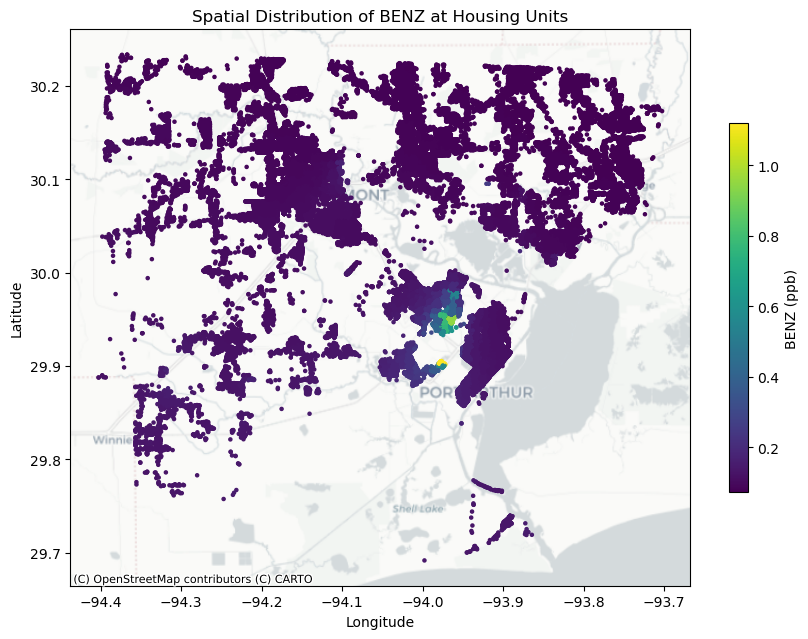

In [64]:
resolution = "1km"
first_pollutant = "BENZ"
# map hua point data with air pollution values
fig, ax = plt.subplots(figsize=(10, 8))
hua_with_hourly_air.plot(column=f'{first_pollutant}', ax=ax, legend=True,
                 cmap='viridis', markersize=5,
                 legend_kwds={'label': f'{first_pollutant} (ppb)', 'shrink': 0.6})
ctx.add_basemap(ax, crs=hua_with_hourly_air.crs, source=ctx.providers.CartoDB.Positron)
plt.title(f"Spatial Distribution of {first_pollutant} at Housing Units")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Add Low-income renter variable

In [51]:
# Create a new variable that identifies low-income renters
# Low income defined as below median randincome

# First, add tenure status and household income group to the data
hua_with_grid_with_demographics = PopResultsTable.add_hhinc_df(hua_with_hourly_air)
hua_with_grid_with_demographics = PopResultsTable.add_tenure_to_pop_df(hua_with_grid_with_demographics)

# Calculate median income for the region (excluding missing values)
median_income = hua_with_grid_with_demographics['randincome'].median()
print(f"Regional median household income: ${median_income:,.0f}")

# Create low-income renter variable
def add_low_income_renter_variable(df):
    """Add Low Income Renter status to dataframe.
    
    Args:
        df (obj): Pandas DataFrame object with randincome and ownershp columns.
    
    Returns:
        object: Pandas DataFrame object with new Low Income Renter Status column.
    """
    # Calculate median income if not already calculated
    median_income = df['randincome'].median()
    
    # Initialize the variable
    df['Low Income Renter Status'] = "Not Low Income Renter"
    df['Low Income Renter Status'].notes = "Identify Low Income Renter Status based on below median income and renter status."
    
    # Define low-income renters: ownershp=2 (renter) AND randincome < median
    low_income_renter_condition = (df['ownershp'] == 2) & (df['randincome'] < median_income) & (df['randincome'].notna())
    df.loc[low_income_renter_condition, 'Low Income Renter Status'] = "Low Income Renter"
    
    # Set to missing for cases with missing income or ownership data
    missing_data_condition = df['randincome'].isna() | df['ownershp'].isna()
    df.loc[missing_data_condition, 'Low Income Renter Status'] = np.nan
    
    return df

# Apply the function
hua_with_grid_with_demographics = add_low_income_renter_variable(hua_with_grid_with_demographics)

# Check the results
print(f"\nLow Income Renter Status distribution:")
print(hua_with_grid_with_demographics['Low Income Renter Status'].value_counts(dropna=False))

# Cross-tabulation to verify the logic
print(f"\nCross-tabulation of Tenure Status vs Low Income Renter Status:")
crosstab = pd.crosstab(
    hua_with_grid_with_demographics['Tenure Status'], 
    hua_with_grid_with_demographics['Low Income Renter Status'], 
    margins=True, 
    dropna=False
)
print(crosstab)

# Show some summary statistics
low_income_renters = hua_with_grid_with_demographics[hua_with_grid_with_demographics['Low Income Renter Status'] == 'Low Income Renter']
if len(low_income_renters) > 0:
    print(f"\nLow-income renter households:")
    print(f"  Count: {len(low_income_renters):,}")
    print(f"  Mean income: ${low_income_renters['randincome'].mean():,.0f}")
    print(f"  Median income: ${low_income_renters['randincome'].median():,.0f}")
    print(f"  Income range: ${low_income_renters['randincome'].min():,.0f} - ${low_income_renters['randincome'].max():,.0f}")

# Show income distribution by income group for low-income renters
if 'Household Income Group' in hua_with_grid_with_demographics.columns:
    print(f"\nLow-income renters by Household Income Group:")
    income_group_crosstab = pd.crosstab(
        hua_with_grid_with_demographics['Household Income Group'], 
        hua_with_grid_with_demographics['Low Income Renter Status'], 
        margins=True, 
        dropna=False
    )
    print(income_group_crosstab)

Regional median household income: $60,412

Low Income Renter Status distribution:
Low Income Renter Status
Not Low Income Renter    136545
Low Income Renter         31569
NaN                       24525
Name: count, dtype: int64

Cross-tabulation of Tenure Status vs Low Income Renter Status:
Low Income Renter Status  Low Income Renter  Not Low Income Renter    NaN  \
Tenure Status                                                               
1 Owner Occupied                          0                 113927      0   
2 Renter Occupied                     31569                  22618      0   
NaN                                       0                      0  24525   
All                                   31569                 136545      0   

Low Income Renter Status       All  
Tenure Status                       
1 Owner Occupied          113927.0  
2 Renter Occupied          54187.0  
NaN                            NaN  
All                       192639.0  

Low-income renter hou

#### Look at summary population data

In [52]:
# Add race ethnicity categories
hua_tfsites_gdf_addrace = PopResultsTable.add_race_ethnicity_to_pop_df(hua_with_grid_with_demographics)

In [53]:
PopResultsTable.pop_results_table(
                  input_df = hua_tfsites_gdf_addrace, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Southeast Texas',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","190,993 (64.4%)","48,649 (37.8%)","239,642 (56.4%)"
"2 Black alone, Not Hispanic","45,982 (15.5%)","50,382 (39.2%)","96,364 (22.7%)"
"3 American Indian and Alaska Native alone, Not Hispanic",883 (0.3%),435 (0.3%),"1,318 (0.3%)"
"4 Asian alone, Not Hispanic","7,896 (2.7%)","3,199 (2.5%)","11,095 (2.6%)"
"5 Other Race, Not Hispanic","7,800 (2.6%)","3,666 (2.9%)","11,466 (2.7%)"
"6 Any Race, Hispanic","42,897 (14.5%)","22,260 (17.3%)","65,157 (15.3%)"
Total,"296,451 (100.0%)","128,591 (100.0%)","425,042 (100.0%)"


In [54]:
# select place name = Beaumont
condition = hua_tfsites_gdf_addrace['placeNAME20'] == 'Beaumont'
beaumont_gdf = hua_tfsites_gdf_addrace[condition]
PopResultsTable.pop_results_table(
                  input_df = beaumont_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Beaumont',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","23,012 (36.3%)","9,237 (19.1%)","32,249 (28.8%)"
"2 Black alone, Not Hispanic","23,456 (37.0%)","29,320 (60.5%)","52,776 (47.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic",134 (0.2%),115 (0.2%),249 (0.2%)
"4 Asian alone, Not Hispanic","2,993 (4.7%)","1,203 (2.5%)","4,196 (3.8%)"
"5 Other Race, Not Hispanic","1,578 (2.5%)","1,262 (2.6%)","2,840 (2.5%)"
"6 Any Race, Hispanic","12,159 (19.2%)","7,346 (15.2%)","19,505 (17.4%)"
Total,"63,332 (100.0%)","48,483 (100.0%)","111,815 (100.0%)"


In [55]:
# look just at site 1
site1_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 1]
PopResultsTable.pop_results_table(
                  input_df = site1_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 1 - West Port Arthur',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",64 (7.2%),47 (4.4%),111 (5.7%)
"2 Black alone, Not Hispanic",678 (76.0%),908 (85.5%),"1,586 (81.2%)"
"3 American Indian and Alaska Native alone, Not Hispanic",1 (0.1%),2 (0.2%),3 (0.2%)
"4 Asian alone, Not Hispanic",14 (1.6%),11 (1.0%),25 (1.3%)
"5 Other Race, Not Hispanic",33 (3.7%),16 (1.5%),49 (2.5%)
"6 Any Race, Hispanic",102 (11.4%),78 (7.3%),180 (9.2%)
Total,892 (100.0%),"1,062 (100.0%)","1,954 (100.0%)"


In [56]:
# look just at site 2
site2_hua_gdf = hua_tfsites_gdf_addrace[hua_tfsites_gdf_addrace['Site_ID'] == 2]
PopResultsTable.pop_results_table(
                  input_df = site2_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 2 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",392 (4.4%),515 (7.3%),907 (5.7%)
"2 Black alone, Not Hispanic","5,003 (56.0%)","4,733 (66.7%)","9,736 (60.8%)"
"3 American Indian and Alaska Native alone, Not Hispanic",6 (0.1%),11 (0.2%),17 (0.1%)
"4 Asian alone, Not Hispanic",218 (2.4%),93 (1.3%),311 (1.9%)
"5 Other Race, Not Hispanic",175 (2.0%),155 (2.2%),330 (2.1%)
"6 Any Race, Hispanic","3,135 (35.1%)","1,585 (22.3%)","4,720 (29.5%)"
Total,"8,929 (100.0%)","7,092 (100.0%)","16,021 (100.0%)"


In [57]:
PopResultsTable.pop_results_table(
                  input_df = hua_tfsites_gdf_addrace, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Southeast Texas',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000","24,445 (8.2%)","17,146 (13.3%)","41,591 (9.8%)"
"2 $15,000 to $24,999","21,648 (7.3%)","12,549 (9.8%)","34,197 (8.0%)"
"3 $25,000 to $74,999","107,633 (36.3%)","52,507 (40.8%)","160,140 (37.7%)"
"4 $75,000 to $99,999","37,557 (12.7%)","13,794 (10.7%)","51,351 (12.1%)"
"5 $100,000 or more","105,168 (35.5%)","32,595 (25.3%)","137,763 (32.4%)"
Total,"296,451 (100.0%)","128,591 (100.0%)","425,042 (100.0%)"


In [58]:
# look just at site 1
PopResultsTable.pop_results_table(
                  input_df = site1_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 1 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000",285 (32.0%),400 (37.7%),685 (35.1%)
"2 $15,000 to $24,999",59 (6.6%),45 (4.2%),104 (5.3%)
"3 $25,000 to $74,999",346 (38.8%),429 (40.4%),775 (39.7%)
"4 $75,000 to $99,999",21 (2.4%),54 (5.1%),75 (3.8%)
"5 $100,000 or more",181 (20.3%),134 (12.6%),315 (16.1%)
Total,892 (100.0%),"1,062 (100.0%)","1,954 (100.0%)"


In [59]:
# look just at site 2
PopResultsTable.pop_results_table(
                  input_df = site2_hua_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = 'Site 2 - Southeast Beaumont',
                  when = '2020',
                  row_index = "Household Income Group",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Household Income Group,,,
"1 Less than $15,000","1,193 (13.4%)","1,085 (15.3%)","2,278 (14.2%)"
"2 $15,000 to $24,999",940 (10.5%),717 (10.1%),"1,657 (10.3%)"
"3 $25,000 to $74,999","4,667 (52.3%)","3,573 (50.4%)","8,240 (51.4%)"
"4 $75,000 to $99,999","1,002 (11.2%)",659 (9.3%),"1,661 (10.4%)"
"5 $100,000 or more","1,127 (12.6%)","1,058 (14.9%)","2,185 (13.6%)"
Total,"8,929 (100.0%)","7,092 (100.0%)","16,021 (100.0%)"


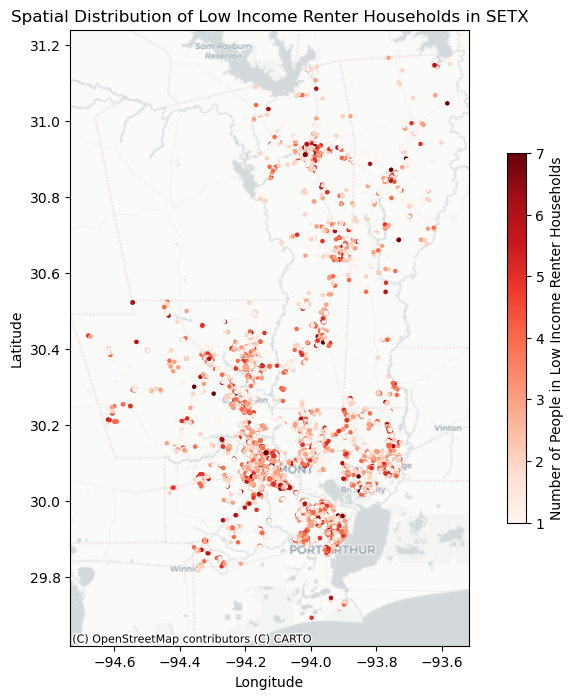

In [66]:
# make heat map using numprec for low income renters 
low_income_renters_gdf = hua_with_grid_with_demographics[hua_with_grid_with_demographics['Low Income Renter Status'] == 'Low Income Renter']
fig, ax = plt.subplots(figsize=(10, 8))
low_income_renters_gdf.plot(column='numprec', ax=ax, legend=True,
                 cmap='Reds', markersize=5,
                 legend_kwds={'label': 'Number of People in Low Income Renter Households', 'shrink': 0.6})
ctx.add_basemap(ax, crs=low_income_renters_gdf.crs, source=ctx.providers.CartoDB.Positron)
plt.title("Spatial Distribution of Low Income Renter Households in SETX")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Low income threshold (10th percentile): $13,629
Low-income renters count: 7,155
People in low-income renter households: 15,314.0
High income threshold (90th percentile): $176,148
High-income homeowners count: 13,034
People in high-income homeowner households: 37,078.0


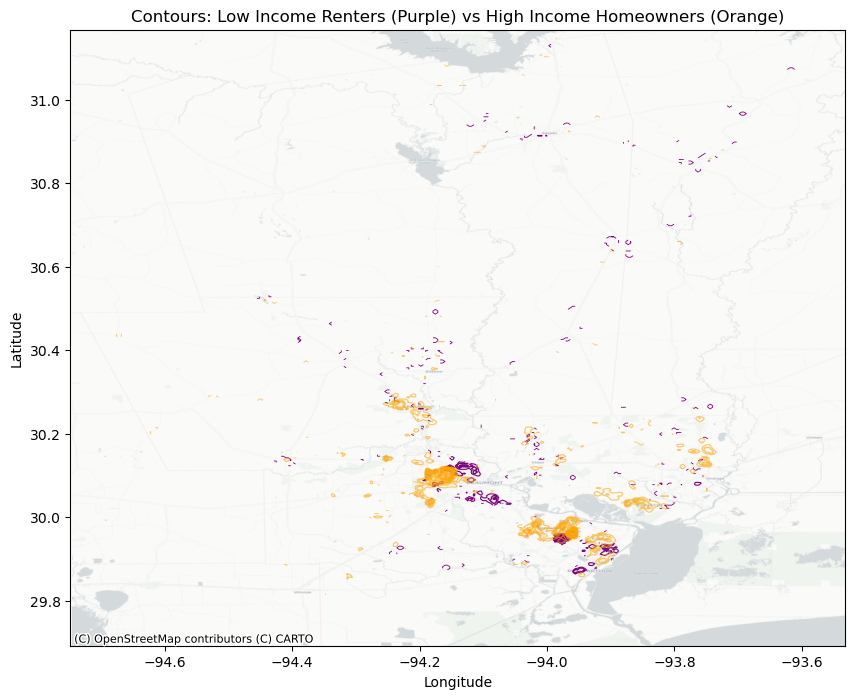

In [96]:
# Heat map as raster with moving window sum of people per cell (lat/long output)
import numpy as np
from matplotlib.colors import LogNorm
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.enums import MergeAlg
from rasterio.warp import calculate_default_transform, reproject, Resampling

try:
    from scipy.ndimage import convolve
except ImportError as exc:
    raise ImportError(
        "scipy is required for the moving window sum. Install it with: pip install scipy"
    ) from exc

def build_people_raster(
    people_gdf,
    value_col="numprec",
    cell_size_m=200,
    window_radius_m=250,
    ):
    if people_gdf.empty:
        raise ValueError("Input GeoDataFrame is empty after filtering.")
    if people_gdf.crs is None:
        raise ValueError("Input GeoDataFrame must have a CRS.")
    if value_col not in people_gdf.columns:
        raise ValueError(f"Missing value column: {value_col}")

    working_gdf = people_gdf.copy()
    if working_gdf.geometry.isna().all():
        raise ValueError("Input GeoDataFrame has no valid geometries.")
    if working_gdf.crs.is_geographic:
        working_gdf = working_gdf.to_crs(working_gdf.estimate_utm_crs())

    minx, miny, maxx, maxy = working_gdf.total_bounds
    pad = window_radius_m
    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    width = int(np.ceil((maxx - minx) / cell_size_m))
    height = int(np.ceil((maxy - miny) / cell_size_m))
    transform = from_origin(minx, maxy, cell_size_m, cell_size_m)

    shapes = (
        (geom, float(val))
        for geom, val in zip(working_gdf.geometry, working_gdf[value_col].fillna(0))
        if geom is not None
    )
    base_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="float32",
        merge_alg=MergeAlg.add,
    )

    radius_cells = int(np.ceil(window_radius_m / cell_size_m))
    y, x = np.ogrid[-radius_cells:radius_cells + 1, -radius_cells:radius_cells + 1]
    kernel = (x * x + y * y) <= (window_radius_m / cell_size_m) ** 2
    kernel = kernel.astype("float32")

    moving_sum = convolve(base_raster, kernel, mode="constant", cval=0.0)

    # Reproject to lat/long for display
    dst_crs = "EPSG:4326"
    dst_transform, dst_width, dst_height = calculate_default_transform(
        working_gdf.crs, dst_crs, width, height, minx, miny, maxx, maxy
    )
    moving_sum_ll = np.zeros((dst_height, dst_width), dtype="float32")
    reproject(
        source=moving_sum,
        destination=moving_sum_ll,
        src_transform=transform,
        src_crs=working_gdf.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
    )

    return {
        "raster": moving_sum_ll,
        "gdf": working_gdf,
        "dst_crs": dst_crs,
        "dst_transform": dst_transform,
    }

def _get_raster_bounds(raster_result):
    raster = raster_result["raster"]
    dst_transform = raster_result["dst_transform"]
    height, width = raster.shape
    left = dst_transform.c
    top = dst_transform.f
    right = left + dst_transform.a * width
    bottom = top + dst_transform.e * height

    if left > right:
        left, right = right, left
    if bottom > top:
        bottom, top = top, bottom

    lat_limit = 85.0511
    bottom = float(np.clip(bottom, -lat_limit, lat_limit))
    top = float(np.clip(top, -lat_limit, lat_limit))
    left = float(np.clip(left, -180.0, 180.0))
    right = float(np.clip(right, -180.0, 180.0))
    if bottom >= top or left >= right:
        epsilon = 1e-4
        if bottom >= top:
            bottom -= epsilon
            top += epsilon
        if left >= right:
            left -= epsilon
            right += epsilon

    return left, bottom, right, top

def plot_people_raster(
    raster_result,
    title="Moving Window Sum of People per Cell",
    basemap=ctx.providers.CartoDB.Positron,
    zoom=11,
    cmap_name="Reds",
    alpha=0.85,
    ax=None,
    ):
    raster = raster_result["raster"]
    dst_crs = raster_result["dst_crs"]

    masked = np.ma.masked_where(raster <= 0, raster)
    if masked.count() == 0:
        raise ValueError("No non-zero values to display. Check inputs or parameters.")
    vmin = float(masked.min())
    vmax = float(masked.max())
    if vmin >= vmax:
        raise ValueError("Raster has constant values; adjust parameters.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure

    left, bottom, right, top = _get_raster_bounds(raster_result)
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ctx.add_basemap(ax, crs=dst_crs, source=basemap, zoom=zoom, reset_extent=False)
    cmap = plt.cm.get_cmap(cmap_name).copy()
    cmap.set_under("white")
    use_log = vmax > 1.0 and vmin > 0
    norm = LogNorm(vmin=max(vmin, 1e-3), vmax=vmax) if use_log else None
    im = ax.imshow(
        masked,
        extent=(left, right, bottom, top),
        origin="upper",
        cmap=cmap,
        norm=norm,
        alpha=alpha,
        zorder=3,
    )
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label(f"Moving window sum (range: {vmin:.0f} to {vmax:.0f})")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    return fig, ax

def plot_people_contours(
    raster_result,
    color="purple",
    levels=10,
    linewidths=1.2,
    linewidth_min=0.6,
    linewidth_max=3.0,
    alpha=1.0,
    show_peaks=False,
    show_peak_labels=False,
    peak_count=5,
    peak_label_count=1,
    peak_marker="x",
    peak_size=60,
    ax=None,
    ):
    raster = raster_result["raster"]
    dst_crs = raster_result["dst_crs"]

    masked = np.ma.masked_where(raster <= 0, raster)
    if masked.count() == 0:
        raise ValueError("No non-zero values to contour. Check inputs or parameters.")
    if float(masked.min()) == float(masked.max()):
        raise ValueError("Raster has constant values; contours not meaningful.")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = ax.figure

    left, bottom, right, top = _get_raster_bounds(raster_result)
    x = np.linspace(left, right, raster.shape[1])
    y = np.linspace(top, bottom, raster.shape[0])
    xx, yy = np.meshgrid(x, y)

    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    if np.isscalar(levels):
        levels = np.linspace(float(masked.min()), float(masked.max()), int(levels))
    if linewidths == "scaled":
        linewidths = np.linspace(linewidth_min, linewidth_max, len(levels))
    cs = ax.contour(
        xx,
        yy,
        masked,
        levels=levels,
        colors=color,
        linewidths=linewidths,
        alpha=alpha,
        zorder=4,
    )
    if show_peaks or show_peak_labels:
        filled = masked.filled(-np.inf)
        flat = filled.ravel()
        peak_count = min(int(peak_count), flat.size)
        peak_idx = np.argpartition(flat, -peak_count)[-peak_count:]
        peak_idx = peak_idx[np.argsort(flat[peak_idx])[::-1]]
        rows, cols = np.unravel_index(peak_idx, filled.shape)
        if show_peaks:
            ax.scatter(
                x[cols],
                y[rows],
                s=peak_size,
                marker=peak_marker,
                color=color,
                edgecolors="white",
                linewidths=0.7,
                zorder=5,
            )
        if show_peak_labels:
            label_count = min(int(peak_label_count), len(rows))
            for idx in range(label_count):
                value = filled[rows[idx], cols[idx]]
                ax.annotate(
                    f"{value:.0f}",
                    xy=(x[cols[idx]], y[rows[idx]]),
                    xytext=(8, 8),
                    textcoords="offset points",
                    color=color,
                    fontsize=9,
                    arrowprops={"arrowstyle": "->", "color": color, "lw": 1.0},
                    zorder=6,
                )
    return fig, ax

# Example groups for comparison (BENZ values only)
#filtered_gdf = hua_with_grid_with_demographics[
#    hua_with_grid_with_demographics["BENZ"].notna()
# ]
filtered_gdf = hua_with_grid_with_demographics.copy()

 # find top 75th percentile of income
low_income = filtered_gdf["randincome"].quantile(0.1)
print(f"Low income threshold (10th percentile): ${low_income:,.0f}")
low_income_renters_gdf = filtered_gdf[
    (filtered_gdf["ownershp"] == 2)
    & (filtered_gdf["randincome"] <= low_income)
 ]
print(f"Low-income renters count: {len(low_income_renters_gdf):,}")
print(f"People in low-income renter households: {low_income_renters_gdf['numprec'].sum():,}")

 # find top 75th percentile of income
high_income = filtered_gdf["randincome"].quantile(0.9)
print(f"High income threshold (90th percentile): ${high_income:,.0f}")
high_income_homeowners_gdf = filtered_gdf[
    (filtered_gdf["ownershp"] == 1)
    & (filtered_gdf["randincome"] >= high_income)
 ]
print(f"High-income homeowners count: {len(high_income_homeowners_gdf):,}")
print(f"People in high-income homeowner households: {high_income_homeowners_gdf['numprec'].sum():,}")

low_income_raster = build_people_raster(low_income_renters_gdf, cell_size_m=400, window_radius_m=500)
high_income_raster = build_people_raster(high_income_homeowners_gdf, cell_size_m=400, window_radius_m=500)

fig, ax = plt.subplots(figsize=(10, 8))
left, bottom, right, top = _get_raster_bounds(low_income_raster)
ax.set_xlim(left, right)
ax.set_ylim(bottom, top)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, zoom=11, reset_extent=False)
plot_people_contours(
    low_income_raster,
    color="purple",
    levels=12,
    linewidths="scaled",
    show_peaks=False,
    show_peak_labels=False,
    peak_count=5,
    peak_marker="x",
    ax=ax,
)
plot_people_contours(
    high_income_raster,
    color="orange",
    levels=12,
    linewidths="scaled",
    alpha=0.6,
    show_peaks=False,
    show_peak_labels=False,
    peak_count=5,
    peak_marker="o",
    ax=ax,
)
ax.set_title("Contours: Low Income Renters (Purple) vs High Income Homeowners (Orange)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [102]:
# Save contours as shapefiles and map them with folium
import geopandas as gpd
from shapely.geometry import LineString, LinearRing, Polygon, MultiLineString, MultiPolygon
from shapely.ops import unary_union, polygonize
import folium

def contours_to_gdf(raster_result, levels=10, output_crs=None):
    raster = raster_result["raster"]
    dst_crs = raster_result["dst_crs"]
    masked = np.ma.masked_where(raster <= 0, raster)
    if masked.count() == 0:
        raise ValueError("No non-zero values to contour.")
    if float(masked.min()) == float(masked.max()):
        raise ValueError("Raster has constant values; contours not meaningful.")

    left, bottom, right, top = _get_raster_bounds(raster_result)
    x = np.linspace(left, right, raster.shape[1])
    y = np.linspace(top, bottom, raster.shape[0])
    xx, yy = np.meshgrid(x, y)
    if np.isscalar(levels):
        levels = np.linspace(float(masked.min()), float(masked.max()), int(levels))

    fig, ax = plt.subplots(figsize=(6, 4))
    cs = ax.contour(xx, yy, masked, levels=levels)
    plt.close(fig)

    records = []
    for level, segments in zip(cs.levels, cs.allsegs):
        for segment in segments:
            if segment.shape[0] < 2:
                continue
            line = LineString(segment)
            records.append({"level": float(level), "geometry": line})
    if not records:
        raise ValueError("No contour geometries were created.")

    gdf = gpd.GeoDataFrame(records, crs=dst_crs)
    if output_crs and gdf.crs != output_crs:
        gdf = gdf.to_crs(output_crs)
    return gdf

def smooth_close_contours_gdf(gdf, simplify_tolerance=0.0001, close_tolerance=0.0001, min_area=0.0):
    if gdf.empty:
        return gdf.copy()

    records = []
    for level, group in gdf.groupby("level") if "level" in gdf.columns else [(None, gdf)]:
        closed_geoms = []
        for geom in group.geometry:
            if geom is None or geom.is_empty:
                continue
            geom_type = geom.geom_type
            if geom_type in ("Polygon", "MultiPolygon"):
                closed_geoms.append(geom)
                continue
            if geom_type == "LineString":
                lines = [geom]
            elif geom_type == "LinearRing":
                lines = [LineString(geom)]
            elif geom_type == "MultiLineString":
                lines = list(geom.geoms)
            else:
                continue
            for line in lines:
                coords = list(line.coords)
                if len(coords) < 4:
                    continue
                if coords[0] != coords[-1]:
                    start = coords[0]
                    end = coords[-1]
                    dx = start[0] - end[0]
                    dy = start[1] - end[1]
                    if (dx * dx + dy * dy) ** 0.5 <= close_tolerance:
                        coords.append(start)
                    else:
                        continue
                ring = LinearRing(coords)
                if not ring.is_valid:
                    continue
                closed_geoms.append(Polygon(ring))

        if not closed_geoms:
            continue

        merged = unary_union(closed_geoms)
        if merged.geom_type == "Polygon":
            polys = [merged]
        elif merged.geom_type == "MultiPolygon":
            polys = list(merged.geoms)
        else:
            polys = list(polygonize(merged))

        if simplify_tolerance and simplify_tolerance > 0:
            polys = [p.simplify(simplify_tolerance, preserve_topology=True) for p in polys]
        if min_area and min_area > 0:
            polys = [p for p in polys if p.area >= min_area]

        for poly in polys:
            if "level" in gdf.columns:
                records.append({"level": float(level), "geometry": poly})
            else:
                records.append({"geometry": poly})

    return gpd.GeoDataFrame(records, crs=gdf.crs)

output_dir = programname
os.makedirs(output_dir, exist_ok=True)

target_crs = low_income_raster["gdf"].crs
low_income_contours_gdf = contours_to_gdf(low_income_raster, levels=12, output_crs=target_crs)
high_income_contours_gdf = contours_to_gdf(high_income_raster, levels=12, output_crs=target_crs)

low_income_contours_gdf = smooth_close_contours_gdf(low_income_contours_gdf)
high_income_contours_gdf = smooth_close_contours_gdf(high_income_contours_gdf)

low_income_contours_path = os.path.join(output_dir, "low_income_renters_contours.shp")
high_income_contours_path = os.path.join(output_dir, "high_income_homeowners_contours.shp")

low_income_contours_gdf.to_file(low_income_contours_path)
high_income_contours_gdf.to_file(high_income_contours_path)

print(f"Saved low-income contours to: {low_income_contours_path}")
print(f"Saved high-income contours to: {high_income_contours_path}")
print(f"Contour shapefile CRS: {target_crs}")

low_contours = gpd.read_file(low_income_contours_path).to_crs("EPSG:4326")
high_contours = gpd.read_file(high_income_contours_path).to_crs("EPSG:4326")

total_bounds = low_contours.total_bounds
if not high_contours.empty:
    hb = high_contours.total_bounds
    total_bounds = [
        min(total_bounds[0], hb[0]),
        min(total_bounds[1], hb[1]),
        max(total_bounds[2], hb[2]),
        max(total_bounds[3], hb[3]),
    ]

south, west, north, east = total_bounds[1], total_bounds[0], total_bounds[3], total_bounds[2]
center = [(south + north) / 2.0, (west + east) / 2.0]

m_contours = folium.Map(location=center, zoom_start=11, tiles=None)
folium.TileLayer("OpenStreetMap", name="OpenStreetMap", control=True).add_to(m_contours)
folium.TileLayer("CartoDB positron", name="CartoDB Positron", control=True).add_to(m_contours)

folium.GeoJson(
    low_contours,
    name="Low Income Renters (Contours)",
    style_function=lambda _: {"color": "purple", "weight": 2, "opacity": 0.8},
).add_to(m_contours)

folium.GeoJson(
    high_contours,
    name="High Income Homeowners (Contours)",
    style_function=lambda _: {"color": "orange", "weight": 2, "opacity": 0.7},
).add_to(m_contours)

folium.LayerControl(collapsed=False).add_to(m_contours)
m_contours.fit_bounds([[south, west], [north, east]])
m_contours

Saved low-income contours to: ip1_2dv2_joinpeopleair\low_income_renters_contours.shp
Saved high-income contours to: ip1_2dv2_joinpeopleair\high_income_homeowners_contours.shp
Contour shapefile CRS: EPSG:32615


C:\Users\nathanael99\AppData\Local\Temp\ipykernel_9784\2564466011.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)



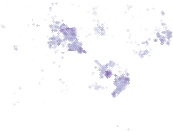
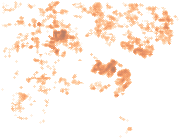

In [ ]:
# Folium map with toggleable raster layers
import base64
import io
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import branca

def raster_to_data_url(raster_result, cmap_name="Purples", alpha=0.7):
    raster = raster_result["raster"]
    left, bottom, right, top = _get_raster_bounds(raster_result)
    masked = np.ma.masked_where(raster <= 0, raster)
    if masked.count() == 0:
        raise ValueError("No non-zero values to display in raster overlay.")
    vmin = float(masked.min())
    vmax = float(masked.max())
    if vmin >= vmax:
        raise ValueError("Raster has constant values; cannot build overlay.")
    if vmin > 0 and vmax > 1.0:
        norm = mcolors.LogNorm(vmin=max(vmin, 1e-3), vmax=vmax)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    rgba = cmap(norm(masked.filled(np.nan)))
    rgba[..., 3] = np.where(masked.mask, 0.0, alpha)
    buffer = io.BytesIO()
    mpimg.imsave(buffer, rgba, format="png")
    data = base64.b64encode(buffer.getvalue()).decode("ascii")
    data_url = f"data:image/png;base64,{data}"
    bounds = [[bottom, left], [top, right]]
    return data_url, bounds

# Build raster overlays
low_income_img, low_income_bounds = raster_to_data_url(
    low_income_raster, cmap_name="Purples", alpha=0.6
 )
high_income_img, high_income_bounds = raster_to_data_url(
    high_income_raster, cmap_name="Oranges", alpha=0.6
 )

# Create map and fit to combined bounds
south = min(low_income_bounds[0][0], high_income_bounds[0][0])
west = min(low_income_bounds[0][1], high_income_bounds[0][1])
north = max(low_income_bounds[1][0], high_income_bounds[1][0])
east = max(low_income_bounds[1][1], high_income_bounds[1][1])
center = [(south + north) / 2.0, (west + east) / 2.0]

m = folium.Map(location=center, zoom_start=11, tiles=None)
folium.TileLayer("OpenStreetMap", name="OpenStreetMap", control=True).add_to(m)
folium.TileLayer("CartoDB positron", name="CartoDB Positron", control=True).add_to(m)

folium.raster_layers.ImageOverlay(
    name="Low Income Renters (Raster)",
    image=low_income_img,
    bounds=low_income_bounds,
    opacity=1.0,
    interactive=True,
    cross_origin=False,
).add_to(m)
folium.raster_layers.ImageOverlay(
    name="High Income Homeowners (Raster)",
    image=high_income_img,
    bounds=high_income_bounds,
    opacity=1.0,
    interactive=True,
    cross_origin=False,
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.fit_bounds([[south, west], [north, east]])
m

# Output files

In [63]:
# Save Work at this point as CSV
savefile = programname+".csv"
savefolder = programname
savefile_path = os.path.join(savefolder, savefile)
hua_with_hourly_air.to_csv(savefile_path, index=False)